<a href="https://colab.research.google.com/github/FranciscoMessina00/HomeworkCMRM2023/blob/main/Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMRM Homework Assignment No. 1 (HW1)

In [16]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
# import other libraries
#!pip install deeplake
#!pip install "deeplake[av]"
import deeplake
#!pip install sklearn
import sklearn
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

## Question 1

In [2]:
# Import dataset
ds = deeplake.load("hub://activeloop/gtzan-genre")

# 16 bit, 22050 Hz, with 352'800 bit/s
ds.summary()

|

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtzan-genre



|

hub://activeloop/gtzan-genre loaded successfully.

Dataset(path='hub://activeloop/gtzan-genre', read_only=True, tensors=['audio', 'genre'])

 tensor      htype              shape             dtype  compression
 -------    -------            -------           -------  ------- 
  audio      audio     (1000, 660000:675808, 1)   None      wav   
  genre   class_label         (1000, 1)          uint32    None   


In [67]:
Fs = 22050
n_samples = 29 * Fs # duration in samples
n_wav = len(ds)
# Define downsampling factors
sub_train = 10
sub_test = 52

# Extract classes
genre_names = ['pop', 'metal', 'classical', 'rock', 'blues', 'jazz', 'hiphop', 'reggae', 'disco', 'country']

# Indexes
i_train = list(range(0, n_wav,sub_train))
i_test = list(range(11, n_wav,sub_test))

genre_train = []
audio_train_list = []
# Extract training set
for i in tqdm(i_train, leave = False, desc='Extracting training set'):
  genre_train.append(ds.genre[i].data()['text'])
  audio_train_list.append(ds.audio[i].numpy()[:n_samples])

audio_train = np.squeeze(np.array(audio_train_list))
print("Shape of genre_train: ", np.shape(genre_train))
print("Shape of audio_train: ", np.shape(audio_train))

# Extract test set
genre_test = []
audio_test_list = []
# Extract training set
for i in tqdm(i_test, leave = False, desc='Extracting testing set'):
  genre_test.append(ds.genre[i].data()['text'])
  audio_test_list.append(ds.audio[i].numpy()[:n_samples])

audio_test = np.squeeze(np.array(audio_test_list))
print("Shape of genre_test: ", np.shape(genre_test))
print("Shape of audio_test: ", np.shape(audio_test))

Extracting training set:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/deeplake/core/tensor.py:714: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


Shape of genre_train:  (100, 1)
Shape of audio_train:  (100, 639450)


Shape of genre_test:  (20, 1)
Shape of audio_test:  (20, 639450)


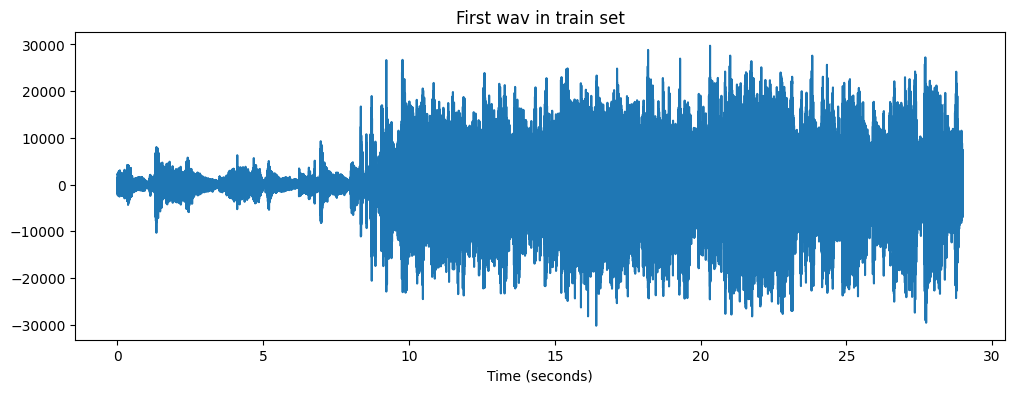

In [21]:
# Plot the first wav in the train set
x_axis = np.arange(0, n_samples) / Fs
plt.figure(figsize=(12, 4))
plt.title('First wav in train set')
plt.xlabel('Time (seconds)')
plt.plot(x_axis, audio_train[0])
plt.show()

## Question 2

In [68]:
# Defining the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Applying the scaler to the lists
audio_train = scaler.fit_transform(audio_train)
audio_test  = scaler.transform(audio_test)

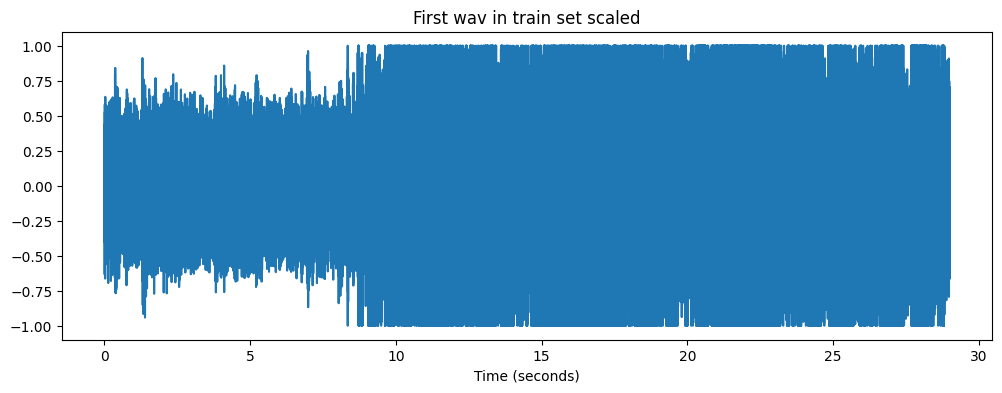

In [60]:
# Plot the first wav in the train set after preprocessing
x_axis = np.arange(0, n_samples) / Fs
plt.figure(figsize=(12, 4))
plt.title('First wav in train set scaled')
plt.xlabel('Time (seconds)')
plt.plot(x_axis, audio_train[0])
plt.show()

In [7]:
# Compute local average
def compute_local_average(x, M):
    """Compute local average of signal

    Args:
        x: Signal
        M: Total length in samples of centric window  used for local average

    Returns:
        local_average: Local average signal
    """

    L = len(x)

    local_average = np.zeros(L)

    for n in range(L):
        a = max(n - M, 0)
        b = min(n + M + 1, L)
        local_average[n] = np.sum(x[a:b]) * (1 / (2*M + 1))
    return local_average

# Compute the principal argument
def principal_argument(x):
    """Principal argument function

    Args:
        x: value (or vector of values)

    Returns:
        y: Principal value of x
    """

    y = np.mod(x + 0.5, 1) - 0.5
    return y

# Compute the Phase-Based Novelty function
def compute_phase_novelty(x, Fs=1, N=1024, H=64, M=40, norm=True, plot=False):
    """Compute phase-based novelty function

    Args:
        x: Signal
        Fs: Sampling rate
        N: Window size
        H: Hop size
        M: Total length in samples of centric window  used for local average
        norm: Apply max norm (if norm==True)
        plot: plot novelty (if plot==True)

    Returns:
        nov: Phase-based novelty function
        Fs_nov: Novelty rate
    """

    # Compute the STFT
    X = librosa.stft(y=x, n_fft=N, hop_length=H, win_length=N, window='hann')
    #X = stft_basic(x, w=np.hanning(N), H=H)

    # Compute the novelty rate
    Fs_nov = Fs/H

    # Extract the phase and use principal_argument
    phase = np.angle(X)/(2*np.pi)

    # first derivative
    phase_d_1 = principal_argument(np.diff(phase, axis=1))
    # second derivative
    phase_d_2 = principal_argument(np.diff(phase_d_1, axis=1))

    # Accumulation over frequency axis
    nov = np.sum(np.abs(phase_d_2), axis=0)
    # Local average subtraction and half-wave rectification
    if M > 0:
      local_average = compute_local_average(nov, M)
      nov = nov - local_average
      nov[nov < 0] = 0

    # Normalization
    if norm:
      max_value = np.max(nov)
      if max_value > 0:
          nov = nov / max_value

    # Plot
    if plot:
      plt.figure(figsize=(12, 4))
      real_t = np.arange(len(nov)) / Fs_nov
      plt.title('First wav novelty')
      plt.xlabel('Time (seconds)')
      plt.plot(real_t, nov)
      plt.show()

    return nov, Fs_nov

def stft_basic(x, w, H=8):
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int)

    X = np.zeros((N, M + 1), dtype='complex')

    for m in range(M+1):
        x_win = x[m*H:m*H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win

    K = (N+1) // 2
    X = X[:K, :]
    return X

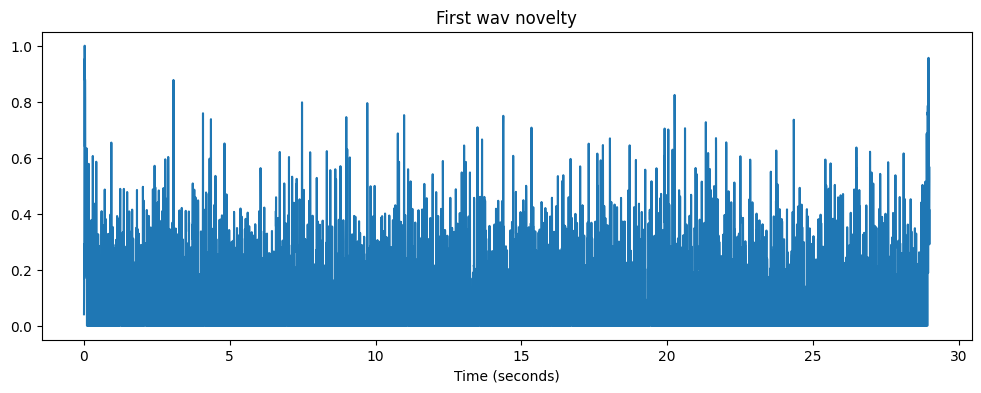

In [8]:
# Test the novelty function on the first wav in the train set
# The hop size can change the sensitivity on phase changes
nov, Fs_nov = compute_phase_novelty(audio_train[0], Fs=22050, plot=True)

## Question 3

In [24]:
def compute_feature_vector(x, Fs, N=2048, H=128):
    """Compute the feature vector

    Args:
        x: Input signal
        Fs: Sampling rate
        N: Window length
        H: Hop size

    Returns:
        f_vector: Feature vector
    """
    # Compute rhythmic features

    # Novelty function and properties
    novelty, Fs_nov = compute_phase_novelty(x=x, Fs=Fs, N=N, H=H)
    std_novelty = np.std(novelty)
    mean_novelty = np.mean(novelty)

    # Tempogram
    tempogram = librosa.feature.tempogram(y=novelty, sr=Fs_nov, hop_length=H, win_length=N)

    # Zero-crossing rate and properties
    zero_cross = librosa.feature.zero_crossing_rate(y=x, hop_length=H)
    std_zero_cross = np.std(zero_cross)
    mean_zero_cross = np.mean(zero_cross)

    # Spectral flux and properties
    spectral_flux = librosa.onset.onset_strength(y=x, sr=Fs)
    std_spectral_flux = np.std(spectral_flux)
    mean_spectral_flux = np.mean(spectral_flux)

    # tempo
    #tempo = librosa.beat.tempo(y=x, sr=Fs)
    tempo = librosa.feature.tempo(y=x, sr=Fs, onset_envelope=spectral_flux, hop_length=H)

    # Concatenate numpy arrays
    f_vector = np.concatenate(
        [novelty,
         Fs_nov,
         std_novelty,
         mean_novelty,
         tempogram,
         zero_cross,
         std_zero_cross,
         mean_zero_cross,
         spectral_flux,
         std_spectral_flux,
         mean_spectral_flux,
         tempo],
        axis=None)

    return f_vector

In [69]:
# Compute feature vector for all the audio files inside the training set
N = 4096
# 128 is the best accuracy value
H = 128

train_fvector = []
for x in tqdm(audio_train, leave=False, desc='Training vector'):
  train_fvector.append(compute_feature_vector(x, Fs, N=N, H=H))


test_fvector = []
for x in tqdm(audio_test, leave=False, desc='Test vector'):
  test_fvector.append(compute_feature_vector(x, Fs, N=N, H=H))


In [70]:
# Check train_fvector and genre_train shapes
print("Shape of train_fvector:", np.shape(train_fvector))
print("Shape of test_fvector:", np.shape(test_fvector))

Shape of train_fvector: (100, 175087)
Shape of test_fvector: (20, 175087)


## Question 4

In [71]:
# Define model parameters

import pickle
from sklearn import svm

# Defining a function to read an existing file or create a new one if it does not exist
def read_or_new_pickle(pathFile):
    if os.path.isfile(pathFile):
        with open(pathFile, "rb") as file:
            try:
                return pickle.load(file)
            except Exception:
                pass
    with open(path, "wb") as file:
      trained_svm = sklearn.svm.SVC(C=C, kernel=kernel).fit(train_fvector, np.ravel(genre_train))
      pickle.dump(trained_svm, file)
    return trained_svm

if not os.path.exists('my_model/'):
    os.mkdir('my_model/')

# Train SVC
C = 1
kernel = 'linear'
path = f'my_model/svc_{kernel}_C_{C}_N_{N}_H_{H}'

trained = read_or_new_pickle(path)

In [72]:
# Print the accuracy on the training set
predictions = trained.predict(train_fvector)
accuracy = accuracy_score(genre_train, predictions)
print(f"Accuracy of training set: {accuracy * 100:.2f}%")

Accuracy of training set: 100.00%


## Question 5

In [73]:
# Classify the test set
predictions = trained.predict(test_fvector)
from warnings              import catch_warnings, filterwarnings
from sklearn.exceptions    import UndefinedMetricWarning

with catch_warnings():
    filterwarnings(action = 'ignore', message = r'.*F-score.*', category = UndefinedMetricWarning)

    # Classify the test set

    print(f'Classification report for classifier:')
    print(classification_report(genre_test, predictions))

Classification report for classifier:
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         2
   classical       0.33      1.00      0.50         2
     country       0.00      0.00      0.00         2
       disco       0.00      0.00      0.00         2
      hiphop       0.00      0.00      0.00         2
        jazz       0.25      0.50      0.33         2
       metal       0.00      0.00      0.00         2
         pop       1.00      1.00      1.00         2
      reggae       0.00      0.00      0.00         2
        rock       0.50      0.50      0.50         2

    accuracy                           0.30        20
   macro avg       0.21      0.30      0.23        20
weighted avg       0.21      0.30      0.23        20



Accuracy of test set: 30.00%


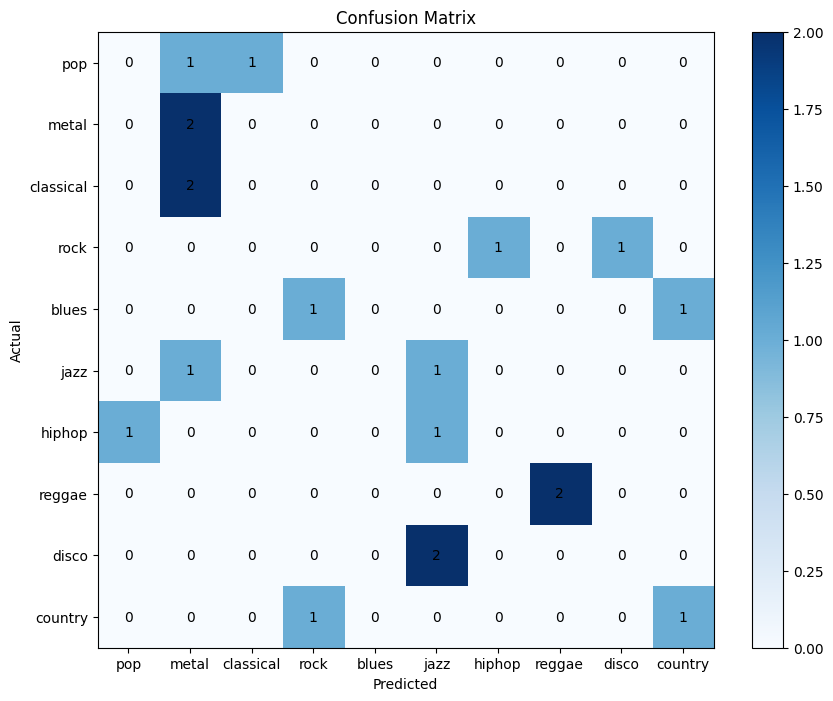

In [74]:
# Print the accuracy
accuracy = accuracy_score(genre_test, predictions)
print(f"Accuracy of test set: {accuracy * 100:.2f}%")

# Plot the confusion matrix
cm = confusion_matrix(genre_test, predictions)
#print("Confusion Matrix:")
#print(cm)

# we can also visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = genre_names
tick_marks = range(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')

# Add annotations
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center',
                 verticalalignment='center', color='black')

plt.show()